In [24]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import cartopy.crs as ccrs
from pyresample import geometry, grid
import pyresample
import random
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [121]:
pc = ccrs.PlateCarree()
pc_params = pc.proj4_params
pc_extents = [-124.25, 32.25, -114.25, 42.25]
shape = [500, 500]
target_area = geometry.AreaDefinition.from_extent('CA', pc_params, shape, pc_extents)

latlon1 = [40.47, -121.465]
latlon2 = [40.675000000000004, -121.155]
coords1 = target_area.get_array_coordinates_from_lonlat(latlon1[1], latlon1[0])
coords1 = (round(coords1[0]), round(coords1[1]))
coords2 = target_area.get_array_coordinates_from_lonlat(latlon2[1], latlon2[0])
coords2 = (round(coords2[0]), round(coords2[1]))
lons = [coords1[0], coords2[0]]
lats = [coords2[1], coords1[1]]

In [171]:
landsat_path = '../landsat_files/landsat_files/'
landsat_img039 = np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_BT3.9_gridA0.02deg.npy')
landsat_img103 = np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_BT10.3_gridA0.02deg.npy')
landsat_img = landsat_img039 - landsat_img103

In [172]:
goes_path = '../landsat_files/'
goes_img039 = np.load(goes_path + 'OR_ABI-L1b-RadC-M6C07_G17_s20212401846176_e20212401848561_c20212401849003.npy')
goes_img103 = np.load(goes_path + 'OR_ABI-L1b-RadC-M6C14_G17_s20212401846176_e20212401848549_c20212401848593.npy')
goes_img = goes_img039 - goes_img103

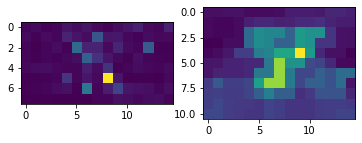

In [173]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(landsat_img)
ax[1].imshow(goes_img[lats[0]:lats[1], lons[0]:lons[1]])

In [182]:
landsat_img[landsat_img < 1] = 0
goes_img[goes_img < 1] = 0

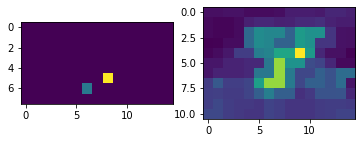

In [185]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(landsat_img)
ax[1].imshow(goes_img[lats[0]:lats[1], lons[0]:lons[1]])

In [174]:
print(landsat_img.shape)
print(goes_img[lats[0]:lats[1], lons[0]:lons[1]].shape)

(8, 15)
(11, 15)


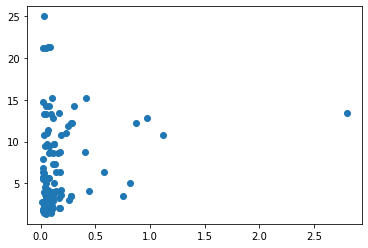

In [175]:
plt.scatter(landsat_img, goes_img[lats[0]:(lats[1]-3), lons[0]:lons[1]])

In [170]:
landsat_path = '../landsat_files/landsat_files/'
landsat_img = np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_BTcounts_grid0.005degA.npy')